<a href="https://colab.research.google.com/github/nitishm08/Titanic-Dataset/blob/master/Titanic_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%cd /content/drive/My Drive/Python for Data Science/13-Logistic-Regression

/content/drive/My Drive/Python for Data Science/13-Logistic-Regression


In [107]:
train_df=pd.read_csv('titanic_train.csv')

In [81]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [82]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [83]:
for column in train_df:
  print('Empty Values in {c} are {n}'.format(c=column,n=sum(train_df[column].value_counts())-891))

Empty Values in PassengerId are 0
Empty Values in Survived are 0
Empty Values in Pclass are 0
Empty Values in Name are 0
Empty Values in Sex are 0
Empty Values in Age are -177
Empty Values in SibSp are 0
Empty Values in Parch are 0
Empty Values in Ticket are 0
Empty Values in Fare are 0
Empty Values in Cabin are -687
Empty Values in Embarked are -2


In [84]:
train_df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


0    549
1    342
Name: Survived, dtype: int64


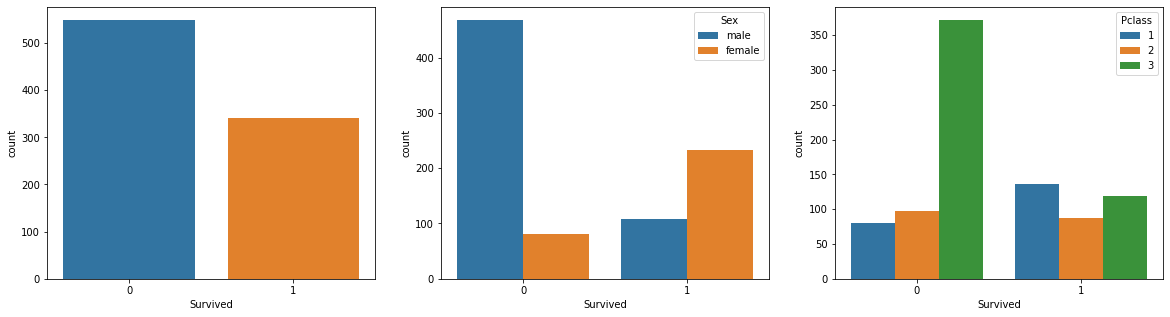

In [85]:
plt.figure(figsize=(20,5))
plt.subplot(131) ;sns.countplot('Survived',data=train_df)
plt.subplot(132) ;sns.countplot('Survived',data=train_df,hue='Sex')
plt.subplot(133) ;sns.countplot('Survived',data=train_df,hue='Pclass')

print(train_df['Survived'].value_counts())

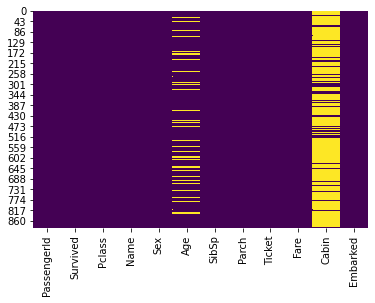

In [108]:
sns.heatmap(train_df.isnull(),cmap='viridis',cbar=False)

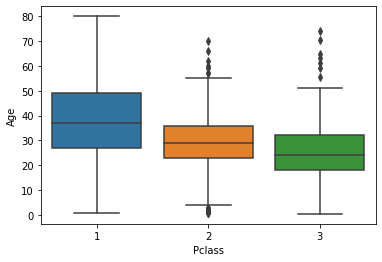

In [87]:
sns.boxplot('Pclass','Age',data=train_df)

In [102]:
def impute_age(cols):
  Age=cols[0]
  Pclass=cols[1]

  if pd.isnull(Age):

    if Pclass==1:
      return 38
    elif Pclass==2:
      return 29
    else:
      return 25
  else:
    return Age

In [111]:
train_df['Age']=train_df[['Age','Pclass']].apply(lambda x : impute_age(x),axis=1)

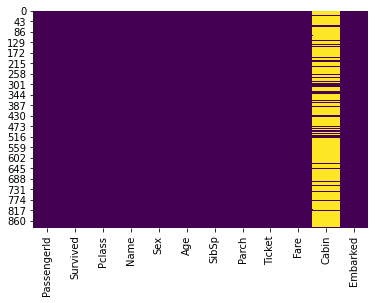

In [112]:
sns.heatmap(train_df.isnull(),cmap='viridis',cbar=False)

In [174]:
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict,cross_val_score,GridSearchCV,RandomizedSearchCV,train_test_split

In [148]:
num_features=list(("Age", "SibSp", "Parch", "Fare"))
cat_features=list(("Pclass", "Sex", "Embarked"))

In [149]:
class MostFrequentImputer(BaseEstimator,TransformerMixin):

  def fit(self,X,y=None):
    self.most_frequent_=pd.Series([X[c].value_counts().index[0] for c in X],
                                  index=X.columns)
    return self
  
  def transform(self,X,y=None):
    return X.fillna(self.most_frequent_)

In [150]:
num_pipeline=Pipeline([
                       ('imputer',SimpleImputer(strategy='median')),
])

In [151]:
cat_pipeline = Pipeline([
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(drop='first',sparse=False)),
    ])

In [152]:
full_pipeline=ColumnTransformer([
                                 ('num_pipe',num_pipeline,num_features),
                                 ('cat_pipe',cat_pipeline,cat_features)
])

In [162]:
X=full_pipeline.fit_transform(train_df)
X

array([[22.,  1.,  0., ...,  1.,  0.,  1.],
       [38.,  1.,  0., ...,  0.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [25.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  1.,  1.,  0.]])

In [163]:
y=train_df['Survived']

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [165]:
rand_clf=RandomForestClassifier()

In [185]:
param_distr=[{'n_estimators':[50,100,150,200,250],'max_features':[1,2,3,4,5,6,7,8]}]

rnd_search=RandomizedSearchCV(rand_clf,param_distributions=param_distr,cv=5,n_iter=10,scoring='accuracy',verbose=2)

rnd_search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, max_features=4 .................................
[CV] .................. n_estimators=50, max_features=4, total=   0.1s
[CV] n_estimators=50, max_features=4 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .................. n_estimators=50, max_features=4, total=   0.1s
[CV] n_estimators=50, max_features=4 .................................
[CV] .................. n_estimators=50, max_features=4, total=   0.1s
[CV] n_estimators=50, max_features=4 .................................
[CV] .................. n_estimators=50, max_features=4, total=   0.1s
[CV] n_estimators=50, max_features=4 .................................
[CV] .................. n_estimators=50, max_features=4, total=   0.1s
[CV] n_estimators=200, max_features=6 ................................
[CV] ................. n_estimators=200, max_features=6, total=   0.4s
[CV] n_estimators=200, max_features=6 ................................
[CV] ................. n_estimators=200, max_features=6, total=   0.4s
[CV] n_estimators=200, max_features=6 ................................
[CV] ................. n_estimators=200, max_features=6, total=   0.4s
[CV] n_estimators=200, max_features=6 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   15.9s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [186]:
rnd_search.best_params_

{'max_features': 6, 'n_estimators': 200}

In [206]:
cvres = rnd_search.cv_results_
for scores,params in zip(cvres["mean_test_score"], cvres["params"]):
    print( scores,params)

0.8061853639318428 {'n_estimators': 50, 'max_features': 4}
0.8118191667487442 {'n_estimators': 200, 'max_features': 6}
0.8062050625430908 {'n_estimators': 250, 'max_features': 6}
0.7991726583275879 {'n_estimators': 250, 'max_features': 3}
0.7865458485176795 {'n_estimators': 50, 'max_features': 8}
0.8104304146557668 {'n_estimators': 150, 'max_features': 6}
0.8090121146459175 {'n_estimators': 200, 'max_features': 5}
0.7963853048360091 {'n_estimators': 250, 'max_features': 1}
0.796375455530385 {'n_estimators': 250, 'max_features': 2}
0.8047867625332413 {'n_estimators': 100, 'max_features': 8}


In [188]:
y_pred=cross_val_predict(RandomForestClassifier(**rnd_search.best_params_),X_test,y_test,cv=3)

In [189]:
print(confusion_matrix(y_test,y_pred))

[[85 20]
 [10 64]]


In [190]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       105
           1       0.76      0.86      0.81        74

    accuracy                           0.83       179
   macro avg       0.83      0.84      0.83       179
weighted avg       0.84      0.83      0.83       179



In [191]:
test_df=pd.read_csv('titanic_test.csv')

In [192]:
for column in test_df:
  print('Empty Values in {c} are {n}'.format(c=column,n=sum(train_df[column].value_counts())-891))

Empty Values in PassengerId are 0
Empty Values in Pclass are 0
Empty Values in Name are 0
Empty Values in Sex are 0
Empty Values in Age are 0
Empty Values in SibSp are 0
Empty Values in Parch are 0
Empty Values in Ticket are 0
Empty Values in Fare are 0
Empty Values in Cabin are -687
Empty Values in Embarked are -2


In [193]:
X_test=full_pipeline.fit_transform(test_df)

In [195]:
y_test_pred=rnd_search.predict(X_test)

In [201]:
submission=pd.DataFrame(y_test_pred,columns=['Survived'])

In [202]:
submission=pd.concat([test_df['PassengerId'],submission],axis=1)

In [204]:
submission.to_csv('Titanic',index=False)